# Проект: семантический анализ области explainable AI
**Данные:** статьи с ресурсов arxiv.org, pubmed содержащие ключевое слово explainable AI в каких-либо частях статьи. Данные собраны за последние 5 лет, выборка с сресурса arxiv.org включает в себя и более старые статьи. \
**Целевая переменная:** для этого корпуса текстов пока не решается задача прогнозиорвания.

In [2]:
import pandas as pd
import string
import re
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sabrinasadieh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sabrinasadieh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sabrinasadieh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Выгрузка данных, базовая предобработка.

In [3]:
path_pubmed = 'data/data_pubmed_explainable_ai_5years.csv'
path_arxiv = 'data/articles_all_explainable_AI_arxiv.23.10.23.csv'

df_arxiv = pd.read_csv(path_arxiv, index_col=0)
df_pubmed = pd.read_csv(path_pubmed, index_col=0)

print(f'Размеры датафреймов:\n \nArxiv: {df_arxiv.shape} \nPubmed: {df_pubmed.shape}')

Размеры датафреймов:
 
Arxiv: (1765, 3) 
Pubmed: (4706, 7)


In [4]:
#Arxiv
df_arxiv.head()

,title,abstract,subm_and_announced_dt
0,\n \n EXPLORA: AI/ML EXPLainabilit...,\n The Open Radio Access Network (RAN) ...,"Submitted 20 October, 2023; \n originally..."
1,\n \n Transparency challenges in p...,\n Causal machine learning tools are be...,"Submitted 19 October, 2023; \n originally..."
2,\n \n Fast and Accurate Factual In...,\n Generative AI models exhibit remarka...,"Submitted 19 October, 2023; \n originally..."
3,\n \n Understanding Addition in Tr...,\n Understanding the inner workings of ...,"Submitted 19 October, 2023; \n originally..."
4,\n \n A Critical Survey on Fairnes...,"\n In this critical survey, we analyze ...","Submitted 15 October, 2023; \n originally..."


In [5]:
#Pubmed
df_pubmed.head()

,title,abstract,keywords,cited_by_cnt,references_cnt,figs_cnt,doi
0,\n\n \n A dual-responsive fluorescent ...,\n\n Abstract\n \n \n\n\n ...,\n\n Keywords:\n \n \n ...,NaN,NaN,NaN,\n doi: 10.1016/j.saa.2023.123348.\n
1,\n\n \n Knowledge Graphs and Their App...,\n\n Abstract\n \n \n\n\n ...,\n\n Keywords:\n \n \n ...,\n 56\n references\n...,\n 56\n references\n...,NaN,\n doi: 10.1007/978-1-0716-3449-3_9.\n ...
2,\n\n \n The future of postoperative vi...,\n\n Abstract\n \n \n\n\n\n...,\n\n Summary:\n \n \n ...,\n 36\n references\n...,\n 36\n references\n...,NaN,\n doi: 10.1097/ACO.0000000000001319.\n...
3,\n\n \n Revisiting the truncated lamin...,\n\n Abstract\n \n \n\n\n ...,\n\n Keywords:\n \n \n ...,\n 19\n references\n...,\n 19\n references\n...,\n 5\n figures\n ...,\n doi: 10.1080/19491034.2023.2262308.\...
4,\n\n \n Microbial ecological clusters ...,\n\n Abstract\n \n \n\n\n ...,\n\n Keywords:\n \n \n ...,NaN,NaN,NaN,\n doi: 10.1016/j.scitotenv.2023.166092...


1. Оценка пропусков и дубликатов.

In [6]:
print('Arxiv')
df_arxiv.isnull().sum()

Arxiv


title                    0
abstract                 0
subm_and_announced_dt    0
dtype: int64

In [7]:
df_arxiv.duplicated().sum()

0

In [8]:
print('Pubmed')
df_pubmed.isnull().sum()

Pubmed


title                0
abstract             0
keywords            11
cited_by_cnt       448
references_cnt    1851
figs_cnt          1557
doi                 28
dtype: int64

In [9]:
df_pubmed.fillna('', inplace = True) #заполняем None значения пустыми строчками, чтобы это не мешало предобратке.

In [10]:
df_arxiv.duplicated().sum()

0

1. Данные с pubmed выгружены хуже, чем с arxiv. В результате анализа отдельных статей при парсинге было выяснено, что попуски в столбцах `keywords`, `cited_by_cnt`, `references_cnt`, `figs_cnt` связаны с просто отсутсвием ключевых слов, цитирований, референсов и изображений у конкретных статей на самом ресурсе. Отстсутвие `doi` может также означать отсутсвие его на сайте.
2. Наиболее важные для частного анализа аннотаций (название, аннотация) заполнены полностью в обоих датафреймах.
3. Сравнение на дубликаты статей планируется провести по предобработанным заголовкам.





## Предобработка текстов и других собранных переменных.
### Часть 1. Базовая предобработка.
Данный раздел посвящен предобработке текстов, представленных в большинстве abstracts (аннотациями) и названиями статей. В частном случае статей с ресурса pubmed прозведена также предобработка ключевых слов, количества цитирований и референсов. В случае arxiv.org также произведена предобработка переменной "год". С ресурса pubmed этих данных получить не удалось.

In [11]:
stopwords = list(stopwords.words("english")) #чтобы добавить — stopwords.extend()

stopwords.extend(['abstract', 'keywords'])

**Заметки по предобработке текстов:**
- *Названия статей нужно будет привести в lowercase и почистить от знаков переноса строки.
- Для предобработки и частного анализа слова привести к начальной форме (лемме). Стемминг не делать, чтобы оставить смысловую нагрузку слов.

**1. Предобработка заголовков.**
- убраны `\n`, произведено приведение к lowercase

In [12]:
%%time
df_pubmed.title = df_pubmed.title.apply(lambda x: x.lower().strip().replace('\n', ''))
df_arxiv.title = df_arxiv.title.apply(lambda x: x.lower().strip().replace('\n', ''))

CPU times: user 7.55 ms, sys: 3.21 ms, total: 10.8 ms
Wall time: 20.5 ms


In [13]:
df_pubmed.head()

,title,abstract,keywords,cited_by_cnt,references_cnt,figs_cnt,doi
0,a dual-responsive fluorescent probe based on c...,\n\n Abstract\n \n \n\n\n ...,\n\n Keywords:\n \n \n ...,,,,\n doi: 10.1016/j.saa.2023.123348.\n
1,knowledge graphs and their applications in dru...,\n\n Abstract\n \n \n\n\n ...,\n\n Keywords:\n \n \n ...,\n 56\n references\n...,\n 56\n references\n...,,\n doi: 10.1007/978-1-0716-3449-3_9.\n ...
2,the future of postoperative vital sign monitor...,\n\n Abstract\n \n \n\n\n\n...,\n\n Summary:\n \n \n ...,\n 36\n references\n...,\n 36\n references\n...,,\n doi: 10.1097/ACO.0000000000001319.\n...
3,revisiting the truncated lamin a produced by a...,\n\n Abstract\n \n \n\n\n ...,\n\n Keywords:\n \n \n ...,\n 19\n references\n...,\n 19\n references\n...,\n 5\n figures\n ...,\n doi: 10.1080/19491034.2023.2262308.\...
4,microbial ecological clusters structured by en...,\n\n Abstract\n \n \n\n\n ...,\n\n Keywords:\n \n \n ...,,,,\n doi: 10.1016/j.scitotenv.2023.166092...


In [14]:
df_arxiv.head()

,title,abstract,subm_and_announced_dt
0,explora: ai/ml explainability for the open ran,\n The Open Radio Access Network (RAN) ...,"Submitted 20 October, 2023; \n originally..."
1,transparency challenges in policy evaluation w...,\n Causal machine learning tools are be...,"Submitted 19 October, 2023; \n originally..."
2,fast and accurate factual inconsistency detect...,\n Generative AI models exhibit remarka...,"Submitted 19 October, 2023; \n originally..."
3,understanding addition in transformers,\n Understanding the inner workings of ...,"Submitted 19 October, 2023; \n originally..."
4,a critical survey on fairness benefits of xai,"\n In this critical survey, we analyze ...","Submitted 15 October, 2023; \n originally..."


**2. Предобратка аннотаций.**

**Pubmed. Заметки:** все аннотации из данных, собранных по pubmed, содержат слово Abstract. Проверить, везде ли аннотации удалось собрать.

In [15]:
count_abs_pubm = df_pubmed.abstract.apply(lambda x: 1 if 'Abstract' in x else 0).sum()
print(f'Собрано аннотаций, {count_abs_pubm}, длина датасета: {len(df_pubmed)}')

Собрано аннотаций, 4686, длина датасета: 4706


Смотрим на выбивающиеся.

In [16]:
df_pubmed.abstract[df_pubmed.abstract.apply(lambda x: 1 if 'Abstract' in x else 0) == 0]

185     \nNo abstract available\n\n\n          Keyword...
216                             \nNo abstract available\n
219                             \nNo abstract available\n
256                             \nNo abstract available\n
380     \nNo abstract available\n\n\n          Keyword...
528                             \nNo abstract available\n
585     \nNo abstract available\n\n\n          Keyword...
721                             \nNo abstract available\n
859     \nNo abstract available\n\n\n          Keyword...
1411    \nNo abstract available\n\n\n          Keyword...
1513    \nNo abstract available\n\n\n          Keyword...
1642                            \nNo abstract available\n
1786                            \nNo abstract available\n
1897    \nNo abstract available\n\n\n          Keyword...
1938                            \nNo abstract available\n
2021                            \nNo abstract available\n
2064    \nNo abstract available\n\n\n          Keyword...
2282    \nNo a

Поскольку у таких наблюдений просто нет аннотации, при придобработке будем заменять её на значение `No abstract available`. В качестве прочей предобратки для первого этапа проведена только очистка знаков переноса (`\n`).

In [17]:
def preprocess_abstracts_pubmed(x):

  if 'Abstract' in x:
    return x.replace('Abstract', '').replace('\n', '')

  else:
    return 'No abstract available'

%time
df_pubmed.abstract = df_pubmed.abstract.apply(lambda x: preprocess_abstracts_pubmed(x))

print(len(df_pubmed.query('abstract == "No abstract available"')))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs
20


In [18]:
df_pubmed.head()

,title,abstract,keywords,cited_by_cnt,references_cnt,figs_cnt,doi
0,a dual-responsive fluorescent probe based on c...,Hypochlorous...,\n\n Keywords:\n \n \n ...,,,,\n doi: 10.1016/j.saa.2023.123348.\n
1,knowledge graphs and their applications in dru...,Knowledge gr...,\n\n Keywords:\n \n \n ...,\n 56\n references\n...,\n 56\n references\n...,,\n doi: 10.1007/978-1-0716-3449-3_9.\n ...
2,the future of postoperative vital sign monitor...,Purpose: ...,\n\n Summary:\n \n \n ...,\n 36\n references\n...,\n 36\n references\n...,,\n doi: 10.1097/ACO.0000000000001319.\n...
3,revisiting the truncated lamin a produced by a...,The Lmna kno...,\n\n Keywords:\n \n \n ...,\n 19\n references\n...,\n 19\n references\n...,\n 5\n figures\n ...,\n doi: 10.1080/19491034.2023.2262308.\...
4,microbial ecological clusters structured by en...,Environmenta...,\n\n Keywords:\n \n \n ...,,,,\n doi: 10.1016/j.scitotenv.2023.166092...


**Arxiv**

In [19]:
df_arxiv['abstract'][0]

'\n        The Open Radio Access Network (RAN) paradigm is transforming cellular networks into a system of disaggregated, virtualized, and software-based components. These self-optimize the network through programmable, closed-loop control, leveraging Artificial Intelligence (AI) and Machine Learning (ML) routines. In this context, Deep Reinforcement Learning (DRL) has shown great potential in addressing complex resource allocation problems. However, DRL -based solutions are inherently hard to explain, which hinders their deployment and use in practice. In this paper, we propose EXPLORA, a framework that provides explainability of DRL-based control solutions for the Open RAN ecosystem. EXPLORA synthesizes network-oriented explanations based on an attributed graph that produces a link between the actions taken by a DRL agent (i.e., the nodes of the graph) and the input state space (i.e., the attributes of each node). This novel approach allows EXPLORA to explain models by providing info

In [20]:
def preprocess_abstracts_arxiv(x):

    return x.replace('△ Less', '').replace('\n', '')


%time
df_arxiv.abstract = df_arxiv.abstract.apply(lambda x: preprocess_abstracts_arxiv(x))


df_arxiv['abstract'][0]

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


'        The Open Radio Access Network (RAN) paradigm is transforming cellular networks into a system of disaggregated, virtualized, and software-based components. These self-optimize the network through programmable, closed-loop control, leveraging Artificial Intelligence (AI) and Machine Learning (ML) routines. In this context, Deep Reinforcement Learning (DRL) has shown great potential in addressing complex resource allocation problems. However, DRL -based solutions are inherently hard to explain, which hinders their deployment and use in practice. In this paper, we propose EXPLORA, a framework that provides explainability of DRL-based control solutions for the Open RAN ecosystem. EXPLORA synthesizes network-oriented explanations based on an attributed graph that produces a link between the actions taken by a DRL agent (i.e., the nodes of the graph) and the input state space (i.e., the attributes of each node). This novel approach allows EXPLORA to explain models by providing inform

**Заметки:** Остались пустые места, но это пока не критично.

**2. Числовые показатели**
Анализ качества для:
- Submitted и announced даты для датасета `arxiv`
-  Количество цитирований, рефернсов, рисунков и год из `doi` для датасета `pubmed`.

**Pubmed:** после сбора было замечено, что столбцы могут содержать иную информацию, если она была указана в теге сайта, вместо целевой.

In [21]:
def _search(x):

  "Функция для анализа категорий, входящих в значения по столбцу на самом деле"

  if x != None:
    x = x.lower()

    if 'cited' in x:

      return 'cit'

    if 'references' in x:
      return 'ref'

    if 'figures' in x:
      return 'figs'

  else:
    return x

df_pubmed.cited_by_cnt.apply(lambda x: _search(x)).value_counts()

cited_by_cnt
cit     3140
ref      985
figs     123
Name: count, dtype: int64

In [22]:
df_pubmed.references_cnt.apply(lambda x: _search(x)).value_counts()

references_cnt
ref    2855
Name: count, dtype: int64

In [23]:
df_pubmed.figs_cnt.apply(lambda x: _search(x)).value_counts()

figs_cnt
figs    2914
Name: count, dtype: int64

Количество цитирований собралось с сайта некорректно. По нему удалось получить только 3140 наблюдений, следовательно далее при рассматривании показателя будут анализироваться они. Все собранные показатели по refernces и figs корректны, но есть пропуски, как было замечено раньше.

В соответствие с классом из каждой строки соберать количества.

In [24]:
def cit_search(x):

  "Функция возвращает число цитирований, если оно указано в строке и 0 иначе."

  x = x.lower()

  pattern = r'\d+'

  if 'cited' in x:
    try:
      data = re.search(pattern, x)
      data = data.group()

      return data

    except:
      return 0

  else:
    return 0

df_pubmed.cited_by_cnt = df_pubmed.cited_by_cnt.apply(lambda x:cit_search(x))

len(df_pubmed.query('cited_by_cnt != 0')) #должно быть 3140

3140

In [25]:
def figs_search(x):

  "Функция возвращает число изображений, если оно указано в строке и 0 иначе."

  x = x.lower()

  pattern = r'\d+'

  if 'figures' in x:
    try:
      data = re.search(pattern, x)
      data = data.group()

      return data

    except:
      return 0

  else:
    return 0

df_pubmed.figs_cnt = df_pubmed.figs_cnt.apply(lambda x:figs_search(x))
len(df_pubmed.query('figs_cnt != 0')) #должно быть 2914

2914

In [26]:
def ref_search(x):

  "Функция возвращает число референсов, если оно указано в строке и 0 иначе."

  x = x.lower()

  pattern = r'\d+'

  if 'references' in x:
    try:
      data = re.search(pattern, x)
      data = data.group()

      return data

    except:
      return 0
  else:
    return 0

df_pubmed.references_cnt = df_pubmed.references_cnt.apply(lambda x:ref_search(x))
len(df_pubmed.query('references_cnt != 0')) #должно быть 2855

2855

In [27]:
df_pubmed.head()

,title,abstract,keywords,cited_by_cnt,references_cnt,figs_cnt,doi
0,a dual-responsive fluorescent probe based on c...,Hypochlorous...,\n\n Keywords:\n \n \n ...,0,0,0,\n doi: 10.1016/j.saa.2023.123348.\n
1,knowledge graphs and their applications in dru...,Knowledge gr...,\n\n Keywords:\n \n \n ...,0,56,0,\n doi: 10.1007/978-1-0716-3449-3_9.\n ...
2,the future of postoperative vital sign monitor...,Purpose: ...,\n\n Summary:\n \n \n ...,0,36,0,\n doi: 10.1097/ACO.0000000000001319.\n...
3,revisiting the truncated lamin a produced by a...,The Lmna kno...,\n\n Keywords:\n \n \n ...,0,19,5,\n doi: 10.1080/19491034.2023.2262308.\...
4,microbial ecological clusters structured by en...,Environmenta...,\n\n Keywords:\n \n \n ...,0,0,0,\n doi: 10.1016/j.scitotenv.2023.166092...


Столбец `doi` решено убрать. Ранее из него планировалось вытащить год публикации, но это возможно не для всех статей, так что столбец не несет информации.

In [28]:
df_pubmed.drop(['doi'], axis=1, inplace=True)

**Arxiv** Вытащен год публикации статьи.

In [29]:
pattern = r'\d{4}'

df_arxiv['year'] = df_arxiv.subm_and_announced_dt.apply(lambda x: re.search(pattern, x).group())

df_arxiv.head()

,title,abstract,subm_and_announced_dt,year
0,explora: ai/ml explainability for the open ran,The Open Radio Access Network (RAN) pa...,"Submitted 20 October, 2023; \n originally...",2023
1,transparency challenges in policy evaluation w...,Causal machine learning tools are begi...,"Submitted 19 October, 2023; \n originally...",2023
2,fast and accurate factual inconsistency detect...,Generative AI models exhibit remarkabl...,"Submitted 19 October, 2023; \n originally...",2023
3,understanding addition in transformers,Understanding the inner workings of ma...,"Submitted 19 October, 2023; \n originally...",2023
4,a critical survey on fairness benefits of xai,"In this critical survey, we analyze ty...","Submitted 15 October, 2023; \n originally...",2023


**3.Предобратка ключевых слов.**

Последний столбец для базовой предобработки

In [30]:
def preprocess_keywords(x):

  if 'keywords:' in x:
    return x.replace('keywords:', '').replace('\n', '')

  else:
    return None

In [31]:
%%time
df_pubmed.keywords = df_pubmed.keywords.apply(lambda x: preprocess_keywords(x.lower())) #lower().replace('keywords:', '').strip()

CPU times: user 11 ms, sys: 1.85 ms, total: 12.8 ms
Wall time: 23 ms


**Данные после базовой предобработки.**

In [32]:
df_pubmed.head()

,title,abstract,keywords,cited_by_cnt,references_cnt,figs_cnt
0,a dual-responsive fluorescent probe based on c...,Hypochlorous...,cell imaging; du...,0,0,0
1,knowledge graphs and their applications in dru...,Knowledge gr...,artificial intel...,0,56,0
2,the future of postoperative vital sign monitor...,Purpose: ...,None,0,36,0
3,revisiting the truncated lamin a produced by a...,The Lmna kno...,lmna deficiency;...,0,19,5
4,microbial ecological clusters structured by en...,Environmenta...,agricultural eco...,0,0,0


In [33]:
#df_pubmed.to_csv('/content/drive/MyDrive/data_science/msk/data/pubmed_cleaned.csv')

In [34]:
df_arxiv.head()

,title,abstract,subm_and_announced_dt,year
0,explora: ai/ml explainability for the open ran,The Open Radio Access Network (RAN) pa...,"Submitted 20 October, 2023; \n originally...",2023
1,transparency challenges in policy evaluation w...,Causal machine learning tools are begi...,"Submitted 19 October, 2023; \n originally...",2023
2,fast and accurate factual inconsistency detect...,Generative AI models exhibit remarkabl...,"Submitted 19 October, 2023; \n originally...",2023
3,understanding addition in transformers,Understanding the inner workings of ma...,"Submitted 19 October, 2023; \n originally...",2023
4,a critical survey on fairness benefits of xai,"In this critical survey, we analyze ty...","Submitted 15 October, 2023; \n originally...",2023


In [35]:
#df_arxiv.to_csv('/content/drive/MyDrive/data_science/msk/data/arxiv_cleaned.csv')

### Часть 2. Углубленная предобработка текстов для частотного анализа.  

In [36]:
lemmatizer = WordNetLemmatizer()


def preprocess_text(text, lemmatizer):

  "Функция осуществляющая приведение текста к виду, где каждое слово представляет собой одну единицу списка. \
  Кроме того, в тексте убираются стоп-слова и производится приведение к lowrcase"
  tokens = word_tokenize(text)
  words = [lemmatizer.lemmatize(t.lower()) for t in tokens if
           # удаляем пунктуацию
            (t not in string.punctuation) &
           # удаляем стоп-слова
            (t.lower() not in stopwords) &
           # удаляем числа
            (not t.isdigit()) &
           # удаляем токены по типу 's
            t.isalpha()
          ]
  text = ' '.join(words)

  return text

#Добавлены слова, касающие области медицины и общих тем, и не являющиеся значимыми для анализа семнатики области.

stopwords.extend(['cell', 'study', 'however', 'patient', 'also', 'protein', 'model', 'patient', 'ai', 'study', 'use', 'may', 'cell', 'research', 'using'])

1. Конкатенация наборов данных. Предобработка аннотаций и названий.

In [37]:
all_papers_df = pd.concat([df_arxiv[['title', 'abstract']], df_pubmed[['title', 'abstract']]]).reset_index(drop=True)
all_papers_df['abstract_clean'] = all_papers_df['abstract'].apply(lambda x: preprocess_text(x, lemmatizer))

In [38]:
all_papers_df['title_clean'] =  all_papers_df['title'].apply(lambda x: preprocess_text(x, lemmatizer))

In [39]:
all_papers_df.head()

,title,abstract,abstract_clean,title_clean
0,explora: ai/ml explainability for the open ran,The Open Radio Access Network (RAN) pa...,open radio access network ran paradigm transfo...,explora explainability open ran
1,transparency challenges in policy evaluation w...,Causal machine learning tools are begi...,causal machine learning tool beginning see pol...,transparency challenge policy evaluation causa...
2,fast and accurate factual inconsistency detect...,Generative AI models exhibit remarkabl...,generative model exhibit remarkable potential ...,fast accurate factual inconsistency detection ...
3,understanding addition in transformers,Understanding the inner workings of ma...,understanding inner working machine learning m...,understanding addition transformer
4,a critical survey on fairness benefits of xai,"In this critical survey, we analyze ty...",critical survey analyze typical claim relation...,critical survey fairness benefit xai


# Анализ полученных данных.
**Цели анализа:**
1. Построить график, отражающий количество статей по области в год, рассмотреть паттерн распределения.
2. Рассмотреть контекстуально-близкие слова с помощью Word2Vec.

**Количество статей в год на ресурсе Arxiv.**

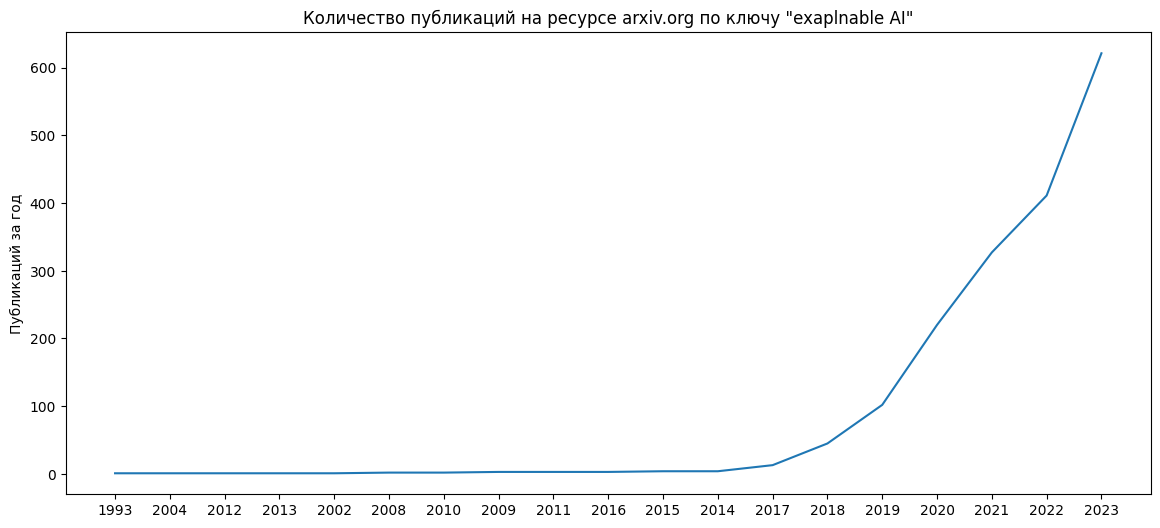

In [44]:
year_dara_arx = pd.DataFrame(df_arxiv['year'].value_counts()).reset_index().sort_values(by='count', ascending=True)

plt.figure(figsize=(14, 6))
plt.plot(year_dara_arx.iloc[:, 0],
         year_dara_arx.iloc[:, 1])

plt.title('Количество публикаций на ресурсе arxiv.org по ключу "exaplnable AI"')
plt.ylabel('Публикаций за год');

1. Хотя не исключено попадание в выборку шумовых данных и статей, относящихся к области explainable AI лишь косвенно, можно отметить, что интерес, если измерять его в количестве публикаций, растет резко, близко к экспоненциальному росту, с начала 2017-2018 года.

Данный факт согласуется с временем выхода статей, демонстрирующих методы, используемые для объяснения моделей искуственного интеллекта сейчас (2023г) ([LIME](https://arxiv.org/abs/1602.04938) — 2016, [SHAP](https://arxiv.org/abs/1705.07874) — 2017, [Permutation importnace](https://arxiv.org/abs/1801.01489) (model agnostic version) — 2018).

**Слова в заголовках. Частнотная популярность.**

In [45]:
def get_sentences_to_wordcloud(column):

  sentences = list(column.values)
  text = [' '.join(i) for i in sentences]

  return text


In [46]:
all_papers_df['title_tokenized'] = all_papers_df['title_clean'].apply(lambda x: word_tokenize(x))
all_papers_df['abstract_tokenized'] = all_papers_df['abstract_clean'].apply(lambda x: word_tokenize(x))


In [47]:
all_papers_df.head()

,title,abstract,abstract_clean,title_clean,title_tokenized,abstract_tokenized
0,explora: ai/ml explainability for the open ran,The Open Radio Access Network (RAN) pa...,open radio access network ran paradigm transfo...,explora explainability open ran,"[explora, explainability, open, ran]","[open, radio, access, network, ran, paradigm, ..."
1,transparency challenges in policy evaluation w...,Causal machine learning tools are begi...,causal machine learning tool beginning see pol...,transparency challenge policy evaluation causa...,"[transparency, challenge, policy, evaluation, ...","[causal, machine, learning, tool, beginning, s..."
2,fast and accurate factual inconsistency detect...,Generative AI models exhibit remarkabl...,generative model exhibit remarkable potential ...,fast accurate factual inconsistency detection ...,"[fast, accurate, factual, inconsistency, detec...","[generative, model, exhibit, remarkable, poten..."
3,understanding addition in transformers,Understanding the inner workings of ma...,understanding inner working machine learning m...,understanding addition transformer,"[understanding, addition, transformer]","[understanding, inner, working, machine, learn..."
4,a critical survey on fairness benefits of xai,"In this critical survey, we analyze ty...",critical survey analyze typical claim relation...,critical survey fairness benefit xai,"[critical, survey, fairness, benefit, xai]","[critical, survey, analyze, typical, claim, re..."


In [48]:
titles_wordcloud = get_sentences_to_wordcloud(all_papers_df.title_tokenized)
abstracts_wordcloud = get_sentences_to_wordcloud(all_papers_df.abstract_tokenized)

In [49]:
def get_wordcloud(text, stopwords, titletext, save=False, **kwargs):

  wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(str(text))
  plt.figure(figsize=(15,10))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.title(titletext, fontsize=16)
  plt.show()

  if save:
    savetitle = kwargs
    plt.save(savetitle)

**Wordcloud по названиям.**

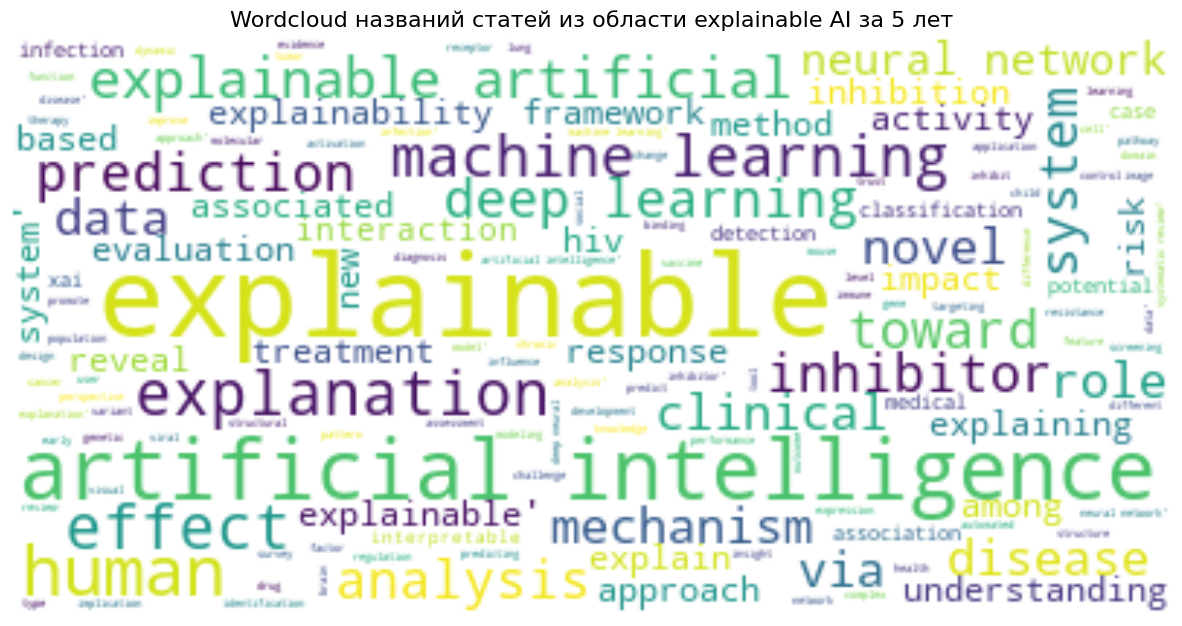

In [50]:
get_wordcloud(titles_wordcloud,
              stopwords,
              titletext='Wordcloud названий статей из области explainable AI за 5 лет', save=False)

In [51]:
from collections import Counter

cnt = Counter(str(titles_wordcloud).split(' '))
print('Топ-10 самых популярных слов в названиях:')
cnt.most_common(10)

Топ-10 самых популярных слов в названиях:


[('learning', 476),
 ('explainable', 450),
 ('artificial', 433),
 ('intelligence', 423),
 ("'explainable", 281),
 ('deep', 250),
 ('human', 245),
 ('explanation', 227),
 ('machine', 216),
 ('network', 196)]

Несмотря на возможные шумовые данные в выборке, облако слов и топ-популярных слов по частоте согласуется с тематикой области. Данный факт позволяет выдвинуть гипотезу о валидности датасета для дальнейшей обработки глубокой моделью.

**Wordcloud по аннотациям.**

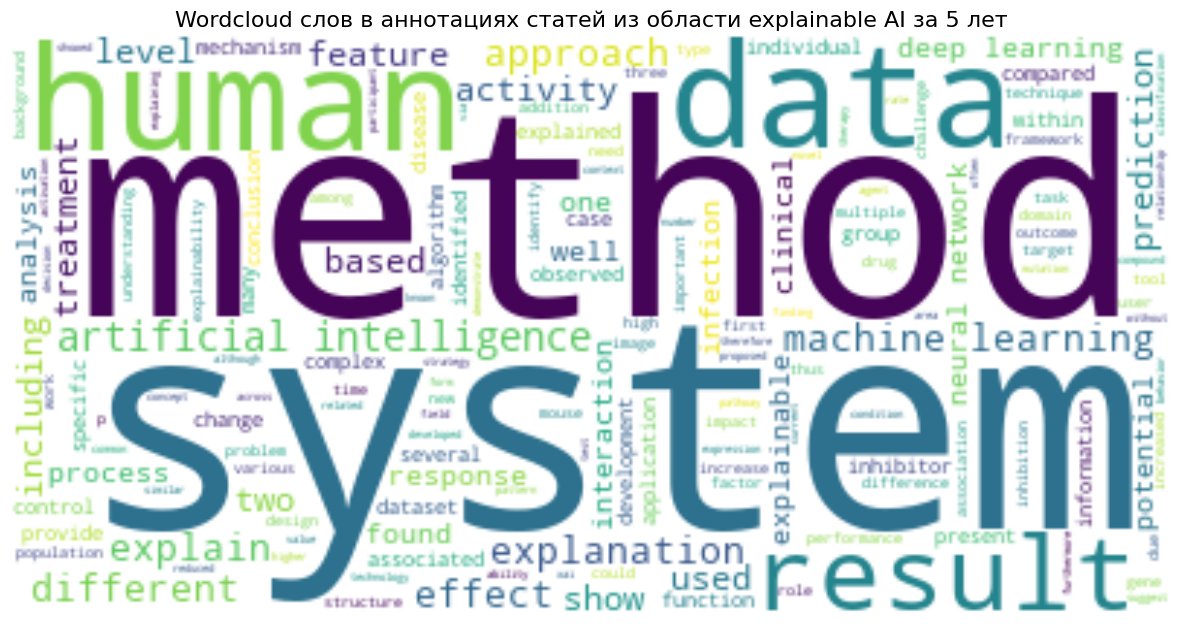

In [52]:
get_wordcloud(abstracts_wordcloud,
              stopwords,
              titletext='Wordcloud слов в аннотациях статей из области explainable AI за 5 лет', save=False)

In [53]:
cnt = Counter(str(abstracts_wordcloud).split(' '))
print('Топ-10 самых популярных слов в аннотациях:')
cnt.most_common(10)

Топ-10 самых популярных слов в аннотациях:


[('data', 3933),
 ('method', 3914),
 ('result', 3780),
 ('model', 3643),
 ('learning', 3624),
 ('system', 3442),
 ('explanation', 2911),
 ('human', 2872),
 ('patient', 2770),
 ('explain', 2687)]

Аналогично облаку по заголовкам, несмотря на возможные шумовые данные в выборке, облако слов и топ-популярных слов по частоте согласуется с тематиками, исследуемыми в области. Однако, топ-10 поплурных слов также указывает, что необходимо провести более глубокий анализ слов и добавить стоп-слова. Так, например, частотная популярность слова `patient` (пациент) скорее вызвана предобладанием в выборке статей по медицинской тематике, чем популярностью исследований в области XAI, относимых к пациентам.  Данный факт подтверждает возможность истинности гипотезы о валидности датасета для дальнейшей обработки глубокой моделью, однако после улгубленного анализа.

**Анализ контекстной близости слов в аннотациях.**

In [54]:
w2v_model = Word2Vec(
    min_count=20,
    window=2,
    vector_size=300,
    alpha=0.03,
    min_alpha=0.0007,
    workers=1,
)

In [55]:
# Формируем словарь

sentences = list(all_papers_df.abstract_tokenized.values)
w2v_model.build_vocab(sentences, progress_per=10000)

In [56]:
# Обучаем модель
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(21263183, 24876030)

In [57]:
# Заранее считаем необходимые нормы для векторов
w2v_model.init_sims(replace=True)

/var/folders/97/cn0tzgm16wq1pvpg99pl3w8h0000gn/T/ipykernel_87205/4078016379.py:2: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


**Анализ контекстной близости слов. Методы.**

Первая группа слов, для которых исследуются близкие слова — наиболее применяемые методы в области — shapley values (aka shap), lime, permutation importance.

In [58]:
def get_similar_words(word, model):

  try:
    words = model.wv.most_similar(positive=word)
    for i in words:
      print(i)
  except KeyError:
    print('Слова нет в словаре')

In [59]:
# Выводим слова, наиболее близкие для слова 'shap'
get_similar_words('shap', w2v_model)

('gradcam', 0.5413976311683655)
('heatmaps', 0.45984816551208496)
('lime', 0.4533911943435669)
('shapley', 0.4400399327278137)
('lrp', 0.42846596240997314)
('saliency', 0.4127887487411499)
('plot', 0.3397613763809204)
('faithful', 0.33946818113327026)
('visualization', 0.3248721659183502)
('cam', 0.32379090785980225)


In [60]:
# Выводим слова, наиболее близкие для слова 'lime'
get_similar_words('lime', w2v_model)

('gradcam', 0.5962067246437073)
('lrp', 0.5399050116539001)
('shap', 0.4533911943435669)
('agnostic', 0.43898507952690125)
('additive', 0.40140533447265625)
('plot', 0.3962485194206238)
('saliency', 0.3921303451061249)
('cam', 0.38569799065589905)
('explainer', 0.37811142206192017)
('shapley', 0.3737489581108093)


In [61]:
# Выводим слова, наиболее близкие для слова 'permutation'
get_similar_words('permutation', w2v_model)

Слова нет в словаре


Контекстуально-близкие слова на основе оценочного расстояние w2v являются осмысленными. Для `lime`, `shap` близкими являются слова, ответственные за названия других методов (`lrp`, `gradcam`, `saliency`, `cam`, `heatmaps`) и слова, примененимые как характеристики методов (`agnostic` (*model agnostic method*), `fainthful` (*верный), `vizualization`). Данный факттакже является фактом "за" адекватность собранного набора данных. Существенным минусом является отсутсвие слова `permutation` в словаре. В качестве будущей работы важно взять на зметку добавление статей с данным методом в корпус.

**Анализ контекстной близости слов. Объяснимость и интерпретируемость.**

Объяснимость и интерпретируемость являются в общем случае различными характеристиками для методов, однако в статьях данный факт иногда игнорируется, что является одним из затрудняющих факторов в отслеживании статей. Прочесть про различие подробно можно [здесь](https://habr.com/ru/articles/744866/). In a nutshell:

- **Интерпретируемость** — преследует цель создания или использования изначально понятной модели.
- **Объяснимость** — преследует цель рассмотрения взаимосвязи между input’ом  и  выходами модели.


In [62]:
w2v_model.wv.most_similar(positive=["interpretable"])

[('comprehensible', 0.44060656428337097),
 ('understandable', 0.43284642696380615),
 ('transparent', 0.41578441858291626),
 ('explainable', 0.3916405141353607),
 ('trustworthy', 0.384280264377594),
 ('generalizable', 0.3623618483543396),
 ('agnostic', 0.3554585576057434),
 ('xai', 0.3513307273387909),
 ('output', 0.34041714668273926),
 ('modular', 0.33946141600608826)]

In [63]:
w2v_model.wv.most_similar(positive=["explainable"])

[('interpretable', 0.3916405737400055),
 ('learning', 0.3907579779624939),
 ('accountable', 0.37910568714141846),
 ('xai', 0.3749989867210388),
 ('explainability', 0.37491321563720703),
 ('transparent', 0.36413854360580444),
 ('automated', 0.35520943999290466),
 ('trustworthy', 0.33662229776382446),
 ('visualization', 0.31913673877716064),
 ('automatic', 0.31371352076530457)]

В целом, слова `interpretable`, `explainable` являются контекстуально близкими друг к другу, что может быть обосновано как применением моделей разных типов в рамках ожной статьи, так и заменяемостью понятий. Вопреки схожести, однако, есть и различные слова (например, `automatic`, `automated`, `accountable` для `explainable`, и `generalizable`, `transparent`, `modular` для `interpretable`). Для уточнения природы таких различий предполагается дальнеший анализ статей из области.

**Анализ контекстной близости слов. Другие слова из области.**

In [64]:
w2v_model.wv.most_similar(positive=["analysis"])

[('profiling', 0.34313562512397766),
 ('calculation', 0.34014809131622314),
 ('genotyping', 0.3061048686504364),
 ('proteomics', 0.284080445766449),
 ('genomics', 0.27306172251701355),
 ('mri', 0.27192047238349915),
 ('plot', 0.2648923695087433),
 ('correction', 0.2623480558395386),
 ('adjustment', 0.2617757022380829),
 ('benchmarking', 0.25942450761795044)]

Обратить внимание на: `genotyping`, `proteomics`, `genomics`.

In [65]:
w2v_model.wv.most_similar(positive=["importance"])

[('necessity', 0.2968243360519409),
 ('contribution', 0.28940248489379883),
 ('significance', 0.2864862084388733),
 ('influential', 0.2761270999908447),
 ('flaw', 0.2668697237968445),
 ('utility', 0.25977960228919983),
 ('relevance', 0.24717894196510315),
 ('antigenicity', 0.2421363890171051),
 ('discriminative', 0.24015675485134125),
 ('need', 0.23882919549942017)]

In [66]:
w2v_model.wv.most_similar(positive=["reliable"])

[('accurate', 0.49259936809539795),
 ('trustworthy', 0.39456993341445923),
 ('reproducible', 0.3708229064941406),
 ('intuitive', 0.36121779680252075),
 ('rigorous', 0.3594914376735687),
 ('scalable', 0.3476341664791107),
 ('transparent', 0.3452705144882202),
 ('preliminary', 0.3385208547115326),
 ('verification', 0.3342669606208801),
 ('interpretable', 0.33380842208862305)]

In [67]:
# Выводим слова, наиболее близкие для слова 'human'
w2v_model.wv.most_similar(positive=["human"])

[('mammalian', 0.25500306487083435),
 ('novice', 0.24228432774543762),
 ('designer', 0.22523602843284607),
 ('readily', 0.22521105408668518),
 ('want', 0.21056480705738068),
 ('dialogue', 0.20927444100379944),
 ('hcmv', 0.20497573912143707),
 ('meaningful', 0.20072755217552185),
 ('symbol', 0.19970297813415527),
 ('everyday', 0.19835340976715088)]

Анализ других слов, применимых к области, подтверждает зашумление данных медицинским контентом (слова `genotyping`, `proteomics`, `genomics` для `analysis`). Для нивелирования данного факта необходимо либо расширить набор данных статьями, связанными с XAI из других областей, либо же провести ручную очистку данных. В лучшем случае следует предпринять оба шага.  

# Общий вывод

Хотя идея датасета является достаточно простой, он сопряжен с двумя трудоемкими задачами — дальнейшей ручной предоработкой и разметкой данных. Базовый анализ показывает необходимость данной предобрабтки, в силу:
- контекстной адекватности корпуса
- базовой наполненности словаря (реализованной, однако, не полностью)
- важности области в настоящее время

Предполагается завершение дальнейшей работы до марта-апреля 2024 года. Работа выполняется с поддержкой гранта от фонда [УМНИК](https://umnik.fasie.ru/).

In [68]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def tsnescatterplot(model, word, list_names):
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    close_words = model.wv.most_similar([word])

    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    reduc = PCA().fit_transform(arrays)

    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

    plt.title('t-SNE visualization for {}'.format(word.title()))

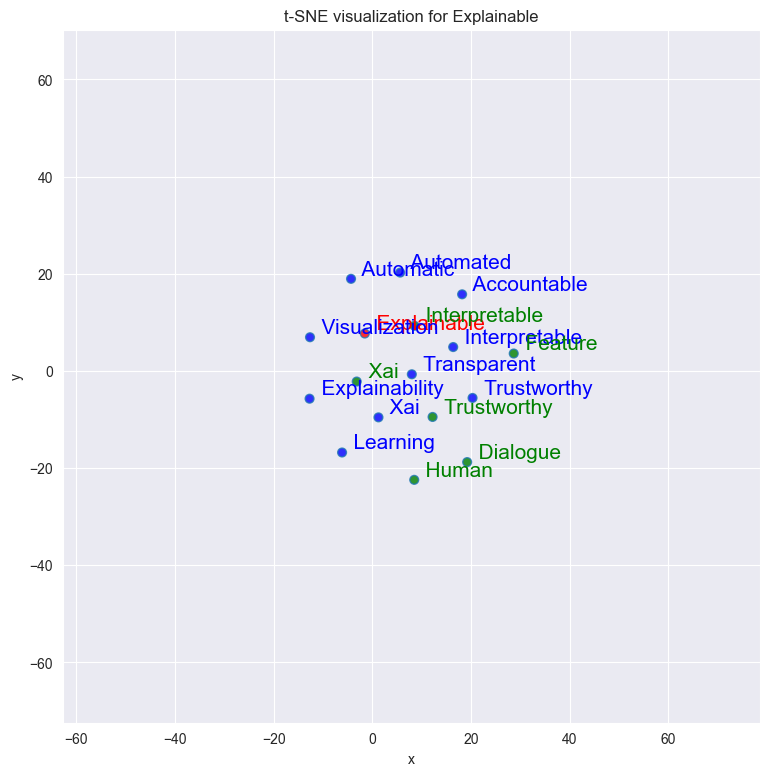

In [69]:
tsnescatterplot(w2v_model, 'explainable', ['interpretable', 'xai', 'human', 'dialogue', 'feature', 'trustworthy'])

(Хотя плохо читаемо, но мне всё равно хочется оставить эту картинку здесь. Видите, как интересно группируются в кластер эти слова? Особенное внимание привлекает слово dialogue, потому как использование диалоговых систем (LLM) один из трендов в XAI сейчас! =))

**Спасибо за чтение и ваше время!**